![image](https://cmip6-preprocessing.readthedocs.io/en/latest/_images/logo.png)

# CMIP6 analysis ready data (ARD) workflow : turning big climate projection data into useful inputs for modelling or analysis

#### **Hackers**: Aditi Modi, Andrew Brettin, Denisse Fierro Arcos, Dhruv Bhagtani, Ibuki Sugiura, Noraini, Rachel Wegener, Shikha Singh, Suman Shekhar

#### **Mentors**: Thomas Moore, Julius Busecke, Paige Martin

<div class="alert alert-block alert-info">
<b>This notebook provides a documented example workflow of how to use the `cmip6_preprocessing` package to read in and visualize several CMIP6 ensemble members, apply a regional mask for the Arabian Sea, and generate a region-averaged timeseries in an analysis-ready and useful format.</b>
</div>

#### Motivation: 
The Climate Model Intercomparison Project - Phase 6 ([CMIP6](https://www.wcrp-climate.org/wgcm-cmip/wgcm-cmip6)) is a collection of global climate models and is a foundation of global climate projections, helping society better understand the choices we must either make or the impact the communities and industries of our children will face.  However there are often barriers (big data, file format, technical terminology) for new users or specific disciplines. Here, we provide an example workflow using the new [cmip6_preprocessing](https://cmip6-preprocessing.readthedocs.io/en/latest/) package.

#### About `cmip6_preprocessing`
`cmip6_preprocessing` is a python package that aims to make CMIP6 data fully analysis ready by fixing issues in a centralized, community driven code base.

#### Goal of this project
To provide an example workflow that is useful for first-time CMIP6 users that could be added to the `cmip6_preprocessing` documentation and/or the [Pangeo Gallery](https://gallery.pangeo.io).

![](https://media.giphy.com/media/SYzDscQMN98G0LUHib/giphy.gif)

## Load and visualize CMIP6 multi-model ensemble

# CMIP6 use case

**Description**

Contents:
* [Loading and filtering the data](#Loading-and-filtering-the-data)
* [Postprocessing and combining the data](#Postprocessing-and-combining-the-data)
* [Visualizing multimodel ensemble](#Visualizing-multimodel-ensemble)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import intake
from dask.diagnostics import ProgressBar

import regionmask
import cartopy.crs as ccrs
import geopandas
import xarray as xr
import pandas as pd

## Loading and filtering the data

In [2]:
# Initialize the Pangeo CMIP6 cloud collection
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [3]:
# View available datasets
col.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hfls,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,zg,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,prw,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
...,...,...,...,...,...,...,...,...,...,...,...
511420,CMIP,CMCC,CMCC-CM2-HR4,abrupt-4xCO2,r1i1p1f1,Amon,sfcWind,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/abrupt...,NaN,20210624
511421,CMIP,CMCC,CMCC-CM2-HR4,abrupt-4xCO2,r1i1p1f1,Amon,uas,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/abrupt...,NaN,20210624
511422,CMIP,CMCC,CMCC-CM2-HR4,abrupt-4xCO2,r1i1p1f1,day,rlut,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/abrupt...,NaN,20210624
511423,ScenarioMIP,AS-RCEC,TaiESM1,ssp585,r1i1p1f1,day,tasmin,gn,gs://cmip6/CMIP6/ScenarioMIP/AS-RCEC/TaiESM1/s...,NaN,20210721


We have a catalog of CMIP datasets that are available on Pangeo, but we would like to filter these results by searching for datasets which match what we want. For instance, we would like to consider models which contain the variables 'tos' and 'no3os' (surface temperature and nitrate concentrations), and we'll also search for models that have both historical and SSP5-8.5 runs.

In [4]:
# function which shows us what different models we have which has specific experiment_id and variable_id
def model_list(experiment_id1, experiment_id2, variable_id1, variable_id2):
    # exp_list_1: all model runs containing experiment "experiment_id1"
    # exp_list_2: all model runs containing experiment "experiment_id2"
    exp_list_1 = col.df[col.df['experiment_id'] == experiment_id1].source_id.unique()
    exp_list_2 = col.df[col.df['experiment_id'] == experiment_id2].source_id.unique()

    # Models which have both experiments experiment_id1 and experiment_id2
    exp_list_intersect = np.intersect1d(exp_list_1, exp_list_2)

    # var_list_1: all model runs containing field "variable_id1"
    # var_list_2: all model runs containing field "variable_id2"
    var_list_1 = col.df[col.df['variable_id'] == variable_id1].source_id.unique()
    var_list_2 = col.df[col.df['variable_id'] == variable_id2].source_id.unique()

    var_list_intersect = np.intersect1d(var_list_1, var_list_2)

    model = np.intersect1d(exp_list_intersect, var_list_intersect)
    return model

model_list('historical','ssp585','tos','no3os')

array(['ACCESS-ESM1-5', 'CESM2', 'CESM2-WACCM', 'CNRM-ESM2-1', 'CanESM5',
       'CanESM5-CanOE', 'GFDL-ESM4', 'GISS-E2-1-G', 'IPSL-CM6A-LR',
       'MIROC-ES2L', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'NorESM2-LM',
       'NorESM2-MM', 'UKESM1-0-LL'], dtype=object)

In [5]:
# Search collection for matching datasets 
models = ['ACCESS-ESM1-5', 'CESM2-WACCM', 'CanESM5', 'IPSL-CM6A-LR']
variables = ['tos', 'no3os']
experiments = ['historical', 'ssp585']

cat = col.search(
    variable_id=variables,
    experiment_id=experiments,
    source_id=models,
    grid_label='gn',
    table_id='Omon',
    member_id = ['r2i1p1f1', 'r3i1p1f1', 'r2i1p2f1', 'r3i1p2f1']
)

In [6]:
# Load using cmip6_preprocessing's combined_preprocessing function
from cmip6_preprocessing.preprocessing import combined_preprocessing

ddict = cat.to_dataset_dict(
    zarr_kwargs={'consolidated':True, 'use_cftime':True}, # recommended for faster reading and better time handling
    storage_options={'token': 'anon'}, # needed to access the public CMIP6 data on google
    aggregate=False,
    preprocess=combined_preprocessing,
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [7]:
# Load in model metrics for later:

cat_m = col.search(
    variable_id=['areacello'], # this is the surface area
    experiment_id=experiments, # Testing this for later
    source_id=models,
)

ddict_metrics = cat_m.to_dataset_dict(
    zarr_kwargs={'consolidated':True, 'use_cftime':True}, # recommended for faster reading and better time handling
    storage_options={'token': 'anon'}, # needed to access the public CMIP6 data on google
    aggregate=False,
    preprocess=combined_preprocessing, # ! Important to apply the preprocessing to the metrics as well!
)

from cmip6_preprocessing.postprocessing import match_metrics
# at the moment the metrics have to be matched before comining datasets
ddict_w_metrics = match_metrics(ddict, ddict_metrics, ['areacello'])


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


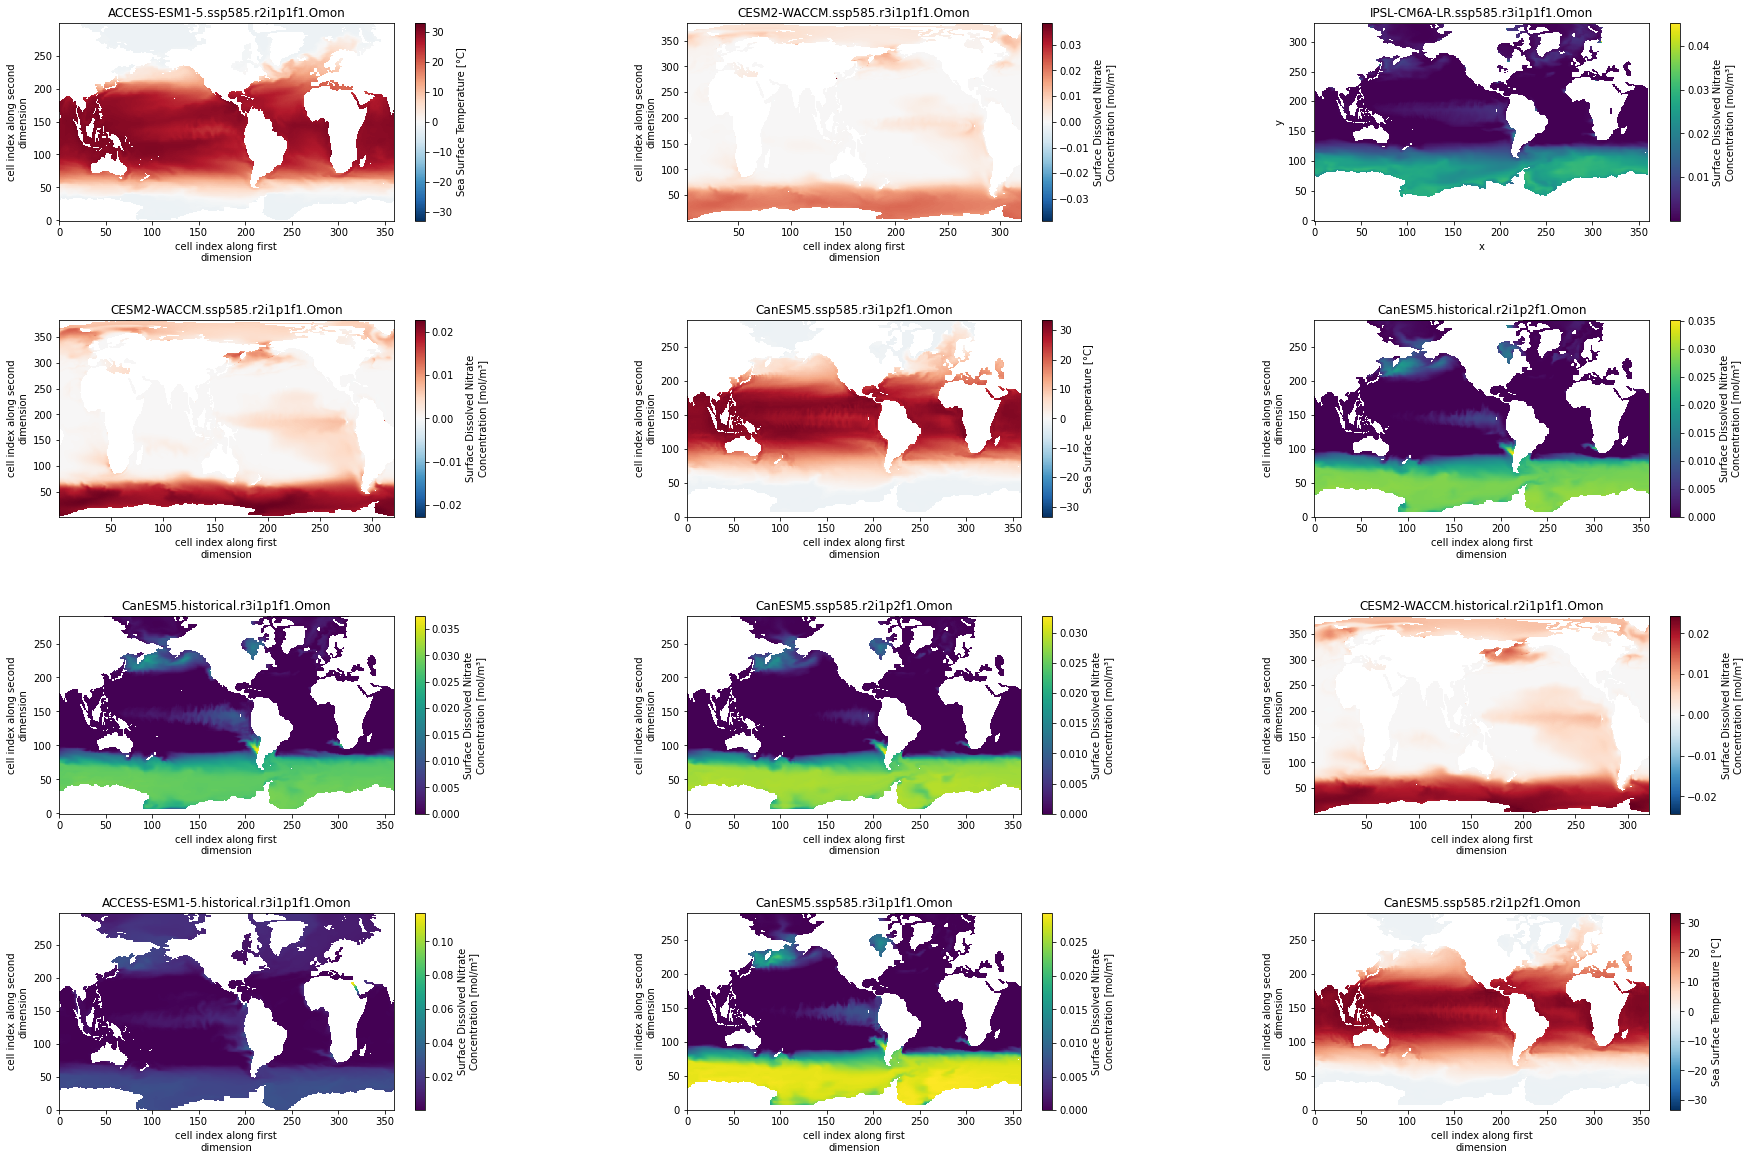

In [8]:
# quick example of how to loop over several models
from cmip6_preprocessing.utils import cmip6_dataset_id
fig, axarr = plt.subplots(ncols=3, nrows=4, figsize=[30,20])
for ax, (name, ds) in zip(axarr.flat, ddict.items()):
    # select the first time step
    ds = ds.isel(time=100)
    # select the datavariable
    da = ds[ds.variable_id]
    # plot
    
    da.plot(ax=ax)
    ax.set_title('.'.join(cmip6_dataset_id(ds).split('.')[2:6]))
    
fig.subplots_adjust(hspace=0.5, wspace=0.5)

## Postprocessing and combining the data

We would like to do the following:
1. Drop any models that do not have _both_ `tos` and `no3os` variables
2. Concatenate historical runs to SSP5-8.5 experiments

In [9]:
from cmip6_preprocessing.postprocessing import merge_variables, concat_members, concat_experiments

In [10]:
ddict_combined_a = merge_variables(ddict_w_metrics)
ddict_combined_a.keys()

dict_keys(['ACCESS-ESM1-5.gn.ssp585.Omon.r2i1p1f1', 'CESM2-WACCM.gn.ssp585.Omon.r3i1p1f1', 'IPSL-CM6A-LR.gn.ssp585.Omon.r3i1p1f1', 'CESM2-WACCM.gn.ssp585.Omon.r2i1p1f1', 'CanESM5.gn.ssp585.Omon.r3i1p2f1', 'CanESM5.gn.historical.Omon.r2i1p2f1', 'CanESM5.gn.historical.Omon.r3i1p1f1', 'CanESM5.gn.ssp585.Omon.r2i1p2f1', 'CESM2-WACCM.gn.historical.Omon.r2i1p1f1', 'ACCESS-ESM1-5.gn.historical.Omon.r3i1p1f1', 'CanESM5.gn.ssp585.Omon.r3i1p1f1', 'IPSL-CM6A-LR.gn.ssp585.Omon.r2i1p1f1', 'CanESM5.gn.historical.Omon.r3i1p2f1', 'ACCESS-ESM1-5.gn.ssp585.Omon.r3i1p1f1', 'ACCESS-ESM1-5.gn.historical.Omon.r2i1p1f1', 'IPSL-CM6A-LR.gn.historical.Omon.r3i1p1f1', 'IPSL-CM6A-LR.gn.historical.Omon.r2i1p1f1', 'CanESM5.gn.historical.Omon.r2i1p1f1', 'CanESM5.gn.ssp585.Omon.r2i1p1f1', 'CESM2-WACCM.gn.historical.Omon.r3i1p1f1'])

In [11]:
def maybe_remove_attrs(ds, attr):
    if attr in ds.attrs.keys():
        del ds.attrs[attr]
    return ds

# remove the `variable_id` attr manually
ddict_combined_aa = {k:maybe_remove_attrs(ds, 'variable_id') for k,ds in ddict_combined_a.items()}
ddict_combined_b = concat_experiments(ddict_combined_aa)
ddict_combined_b.keys()

# same thing for experiment_id
ddict_combined_bb = {k:maybe_remove_attrs(ds, 'experiment_id') for k,ds in ddict_combined_b.items()}
ddict_combined = concat_members(ddict_combined_bb)
ddict_combined.keys()

dict_keys(['ACCESS-ESM1-5.gn.Omon', 'CESM2-WACCM.gn.Omon', 'IPSL-CM6A-LR.gn.Omon', 'CanESM5.gn.Omon'])

In [12]:
# Drop any datasets without both 'tos' and 'no3os'
for model_run in list(ddict_combined.keys()):
    if 'tos' not in ddict_combined[model_run] or 'no3os' not in ddict_combined[model_run]:
        ddict_combined.pop(model_run)

# Print new list of model runs, dropping any model runs that don't have both 'tos' and 'no3os'
ddict_combined.keys()

dict_keys(['ACCESS-ESM1-5.gn.Omon', 'CESM2-WACCM.gn.Omon', 'IPSL-CM6A-LR.gn.Omon', 'CanESM5.gn.Omon'])

## Visualizing multimodel ensemble

Goals:
1. Plot timeseries of mean for each variable
2. Different colors for different models
3. Plot model means as well
4. Plot model variance
3. Account for grid area sizes

[########################################] | 100% Completed |  5.5s
[########################################] | 100% Completed |  6.3s
[########################################] | 100% Completed |  7.5s
[########################################] | 100% Completed |  7.5s
[########################################] | 100% Completed |  5.9s
[########################################] | 100% Completed |  6.1s
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  4.9s


[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Global mean surface temperature [degrees C]'),
 Text(0.5, 1.0, 'Global mean surface temperature [historical + SSP5-8.5 projection]')]

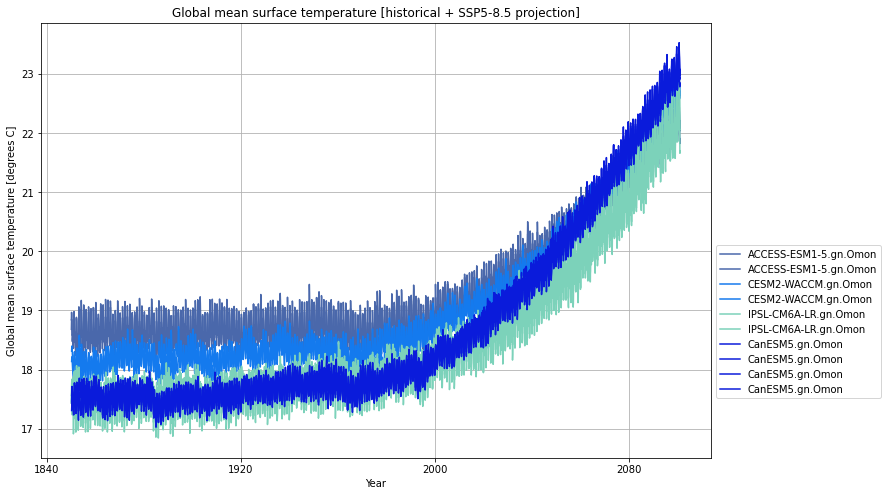

In [13]:
# Plot all ensemble members from all models
fig, ax = plt.subplots(figsize=(12,8))
ax.grid()

for model_run in list(ddict_combined.keys()):
    # Select dataset from ddict_combined
    ds = ddict_combined[model_run]
    
    # Generate random color for plotting
    random_color = np.random.rand(3)
    with ProgressBar():
        # Iterate through ensemble members of each model
        for member in ddict_combined[model_run].member_id:
            temp = ds['tos'].sel(member_id=member)
            global_avg_temp = temp.weighted(temp.areacello.fillna(0)).mean(dim=['x', 'y'])
            global_avg_temp.plot(ax=ax, color=random_color, label=model_run)

ax.legend(bbox_to_anchor=(1,0.5))
ax.set(
    xlabel='Year', 
    ylabel='Global mean surface temperature [degrees C]', 
    title='Global mean surface temperature [historical + SSP5-8.5 projection]'
)

---
_Other work here below_

## Apply regional mask and generate region-averaged timeseries with appropriate weighting

### Accessing sea surface temperature data using ACCESS-ESM 1.5 model
Using one model and one variable initially to develop the script.

In [14]:
# create a subcollection with certain search criteria
cat = col.search(
    #Set the variables that you want to search for
    variable_id = 'tos',
    source_id = 'ACCESS-ESM1-5',
    #Eperiments of interest
    experiment_id = ['historical', 'ssp585'],
    #Native grid
    grid_label = 'gn',
    #Monthly ocean data
    table_id = 'Omon',
    member_id = 'r22i1p1f1'
)


# load all datasets into a python dictionary
ddict = cat.to_dataset_dict(
    zarr_kwargs={'consolidated':True, 'use_cftime':True}, # recommended for faster reading and better time handling
    storage_options={'token': 'anon'}, # needed to access the public CMIP6 data on google
    aggregate=False
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [15]:
SST = ddict['CMIP.CSIRO.ACCESS-ESM1-5.historical.r22i1p1f1.Omon.tos.gn.gs://cmip6/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r22i1p1f1/Omon/tos/gn/v20200922/.nan.20200922']
SST

<xarray.Dataset>
Dimensions:             (i: 360, j: 300, time: 1980, bnds: 2, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 293 294 295 296 297 298 299
    latitude            (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
  * time                (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    tos                 (time, j, i) float32 dask.array<chunksize=(201, 300, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
Attributes: (12/52)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   175317.0
    cmor_version:            3.4.0
    ...                      ...
    variable_id:             tos
    variant_label:           r22i1p1f1
    version:                 v20200922
    version_id:              v20200922
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP.CSIRO.ACCESS-ESM1-5.historical.r22i1p1f1.Om...

In [16]:
def corrcoords(array):
    '''
    Inputs:
    array - Data array on which longitude corrections will be applied.
    
    Output:
    Data array with corrected longitude values.
    '''
    
    #Making a deep copy of original longitude values in the array being corrected
    lon = array['longitude'][0].values
    
    #Values changed from 0-360 to between -180 and +180.
    lon[np.where(lon > 180)] = lon[np.where(lon >180)]-360
    
    #Assigning corrected longitudes and latitude values to i and j, which are index based
    array.coords['i'] = lon
    array.coords['j'] = array['latitude'][:,0].values
    
    #Removing latitude and longitude dimensions and renaming i and j dimensions
    array = array.drop(('latitude', 'longitude'))
    array = array.rename(({'i':'longitude', 'j':'latitude'}))
    
    #Longitude values must be sorted from smallest to largest prior to plotting
    array = array.sortby(array.longitude)
    
    return array

In [17]:
SST_SO = corrcoords(SST.tos).sel(latitude = slice(-90, -30))

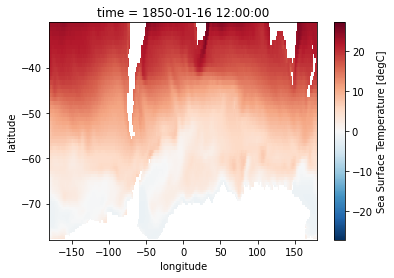

In [18]:
SST_SO[0].plot()

### Loading shapefile with regions of interest
Using `geopandas` to read shapefile and `regionmask` to create the mask to be applied to the dataset.  
For this notebook, a subset of the MEASO regions [https://soki.aq/pages/viewpage.action?pageId=61210912], use to carry out ecosystem assessments in the Southern Ocean, will be used.

<AxesSubplot:>

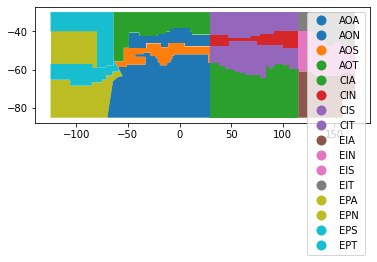

In [19]:
measo = geopandas.read_file('shapefiles/measo_wgs84.shp')

#West Pacific regions are removed because they have duplicate names as the boundaries straddle the -180/180 boundary
measo_sub = measo.query("sector != 'West Pacific'")

#Plotting subset for reference
measo_sub.plot(column = 'name', legend = True)

### Creating an xarray mask of the MEASO regions

In [20]:
#Defining the extent of the shapefile in lat and lon
longitude = SST_SO['longitude'].values
latitude = SST_SO['latitude'].values

#Creating a 3D mask, which includes regions as a dimension
mask3D = regionmask.mask_3D_geopandas(measo_sub, longitude, latitude)
mask3D

<xarray.DataArray 'region' (region: 16, lat: 77, lon: 360)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * lat      (lat) float64 -77.88 -77.63 -77.38 -77.13 ... -32.5 -31.5 -30.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * region   (region) int64 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20

In [21]:
#Creating a dictionary with region names
names = regionmask.from_geopandas(measo_sub, names = "name", name = "name")

#Creating a new variable with the names of regions
reg = []
[reg.append(names[i].name) for i in mask3D.region.values]

#Replacing numbered regions for names in the mask
mask3D['region'] = reg

#Checking results
mask3D.region

<xarray.DataArray 'region' (region: 16)>
array(['EPA', 'EPS', 'EPN', 'EPT', 'AOA', 'AOT', 'AOS', 'AON', 'CIA', 'CIS',
       'CIN', 'CIT', 'EIA', 'EIS', 'EIN', 'EIT'], dtype='<U3')
Coordinates:
  * region   (region) <U3 'EPA' 'EPS' 'EPN' 'EPT' ... 'EIA' 'EIS' 'EIN' 'EIT'

### Applying masks

In [22]:
mask3D = mask3D.rename({'lon': 'longitude','lat': 'latitude'})
masked_SST = (mask3D * SST_SO)

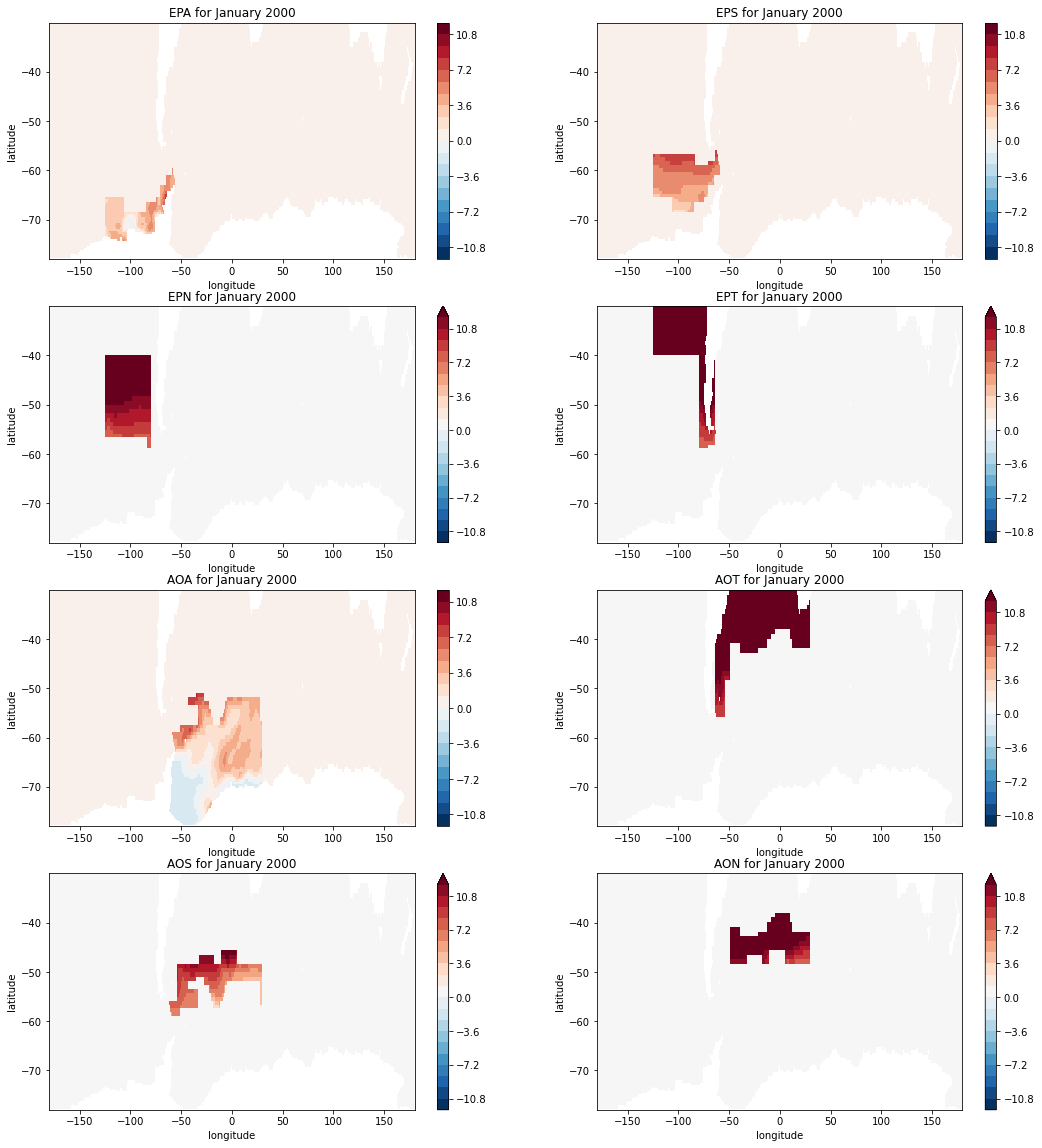

In [23]:
fig, axarr = plt.subplots(ncols = 2, nrows = 4, figsize = (18,20))
for ax, (key) in zip(axarr.flat, masked_SST.region.values):
    masked_SST.sel(region = key).sel(time = slice('2000-01-01', '2000-01-31')).mean('time').plot(ax = ax, levels = np.linspace(-12, 12, 21))
    ax.set_title(key + ' for January 2000')

## Apply regional mask to combined datasets
Instead of applying regional mask on one model, we can do so on a set of model ensembles

We are using: Combined dataset from postprocessing section `ddict_combined`
1. Models include projections for `tos` and `no3os` variables
2. Historical runs and SSP5-8.5 experiments are grouped into one set of data (under one dictionary key)

### Correct coordinates from 0-360 to -180-180

In [24]:
# Importing coordinate conversion functions from pyoceans (https://github.com/pyoceans/python-oceans/blob/master/oceans/ocfis.py)
def wrap_lon180(lon):
    lon = np.atleast_1d(lon)
    angles = np.logical_or((lon < -180), (180 < lon))
    lon[angles] = wrap_lon360(lon[angles] + 180) - 180
    return lon


def wrap_lon360(lon):
    lon = np.atleast_1d(lon)
    positive = lon > 0
    lon = lon % 360
    lon[np.logical_and(lon == 0, positive)] = 360
    return lon

In [25]:
for key in ddict_combined:
    lon = ddict_combined[key]["lon"]
    new_lon = wrap_lon180(ddict_combined[key]["lon"])
    ddict_combined[key]["lon"] = xr.DataArray(new_lon, coords=lon.coords, dims = lon.dims, name = lon.name, attrs = lon.attrs)

### Mask a ocean basin using ocean basin index

We want to show:
1. How to find index number for a particular ocean basin
2. How to mask an individual ocean basin

<GeoAxesSubplot:>

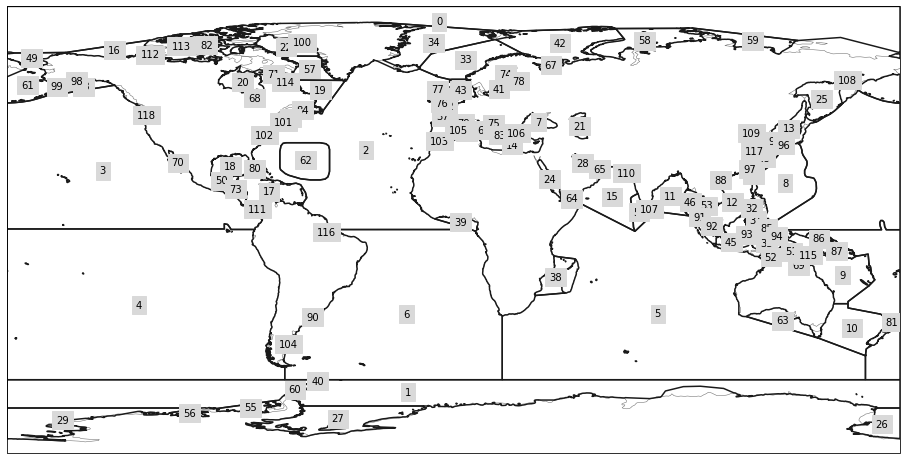

In [26]:
import regionmask
from cmip6_preprocessing.regionmask import merged_mask
# load ocean basin data
basins = regionmask.defined_regions.natural_earth.ocean_basins_50

# map of ocean basins with index
fig = plt.figure(figsize=(16,12))
basins.plot()

Find the index of Arabian Sea

In [27]:
# copied from Julius's notebook
[(ri, r) for ri, r in zip(basins.region_ids, basins.abbrevs) if 'Arabian' in r]

[(15, 'Arabian Sea')]

In [31]:
ddict_combined_masked = ddict_combined.copy()
for key in ddict_combined_masked:
    mask = basins.mask(ddict_combined_masked[key])
    mask_arabian_sea = mask==15
    ddict_combined_masked[key] = ddict_combined_masked[key].where(mask_arabian_sea)

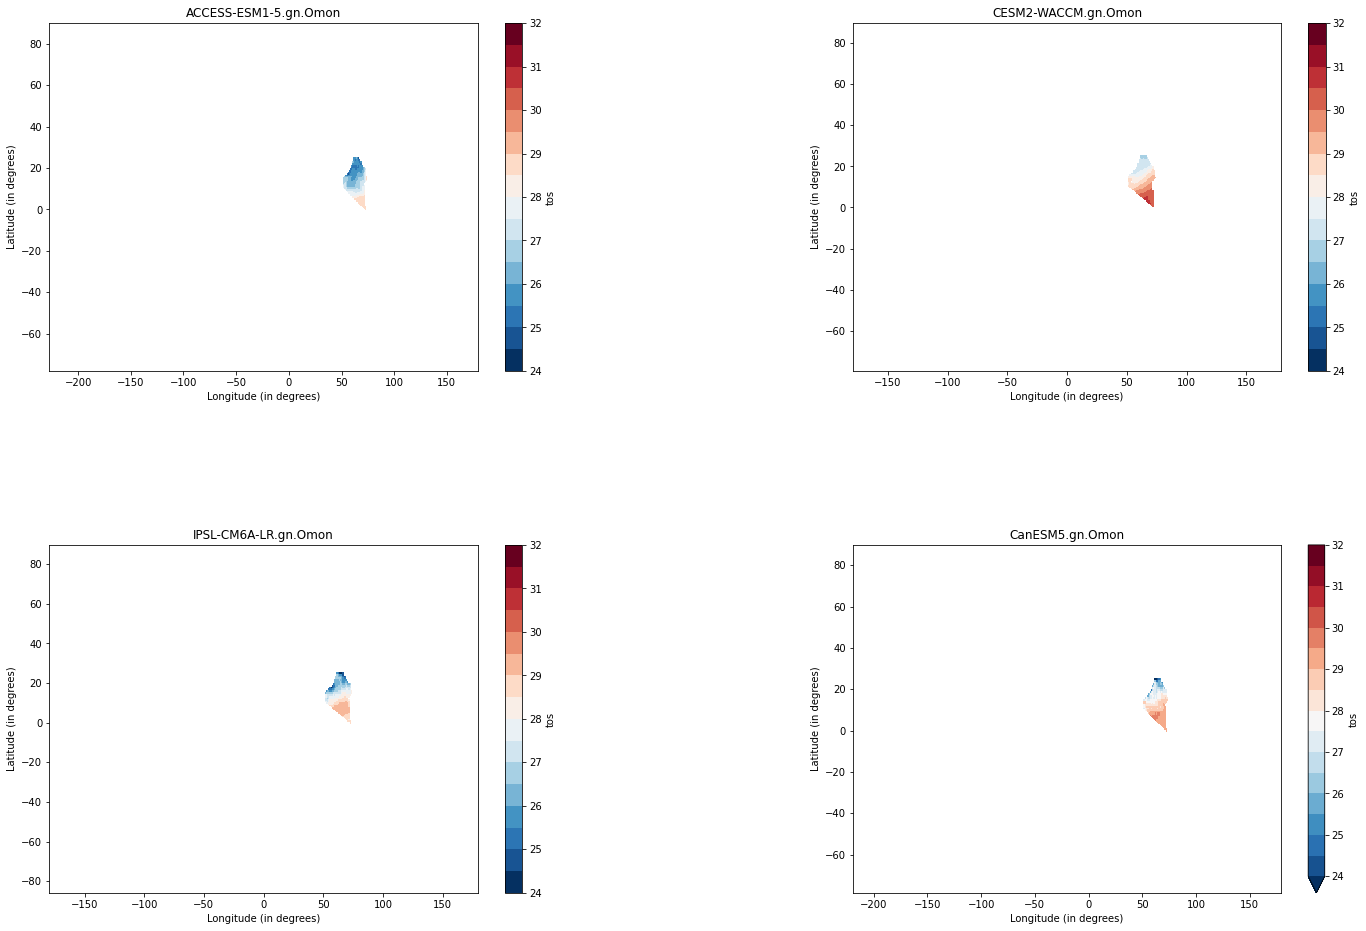

In [56]:
# Mask out only the arabian sea
with np.errstate(divide='ignore', invalid='ignore'):
    fig, axarr = plt.subplots(ncols = 2, nrows = 2, figsize = (24,16))
    for ax, (name, ds) in zip(axarr.flat, ddict_combined_masked.items()):
    
        masked_dn = ds.isel(time = 100).tos
    
        # average all members
        if 'member_id' in masked_dn.dims:
            masked_dn = masked_dn.mean('member_id')
    
        # plotting
        masked_dn.plot(ax = ax, x = 'lon', y = 'lat', levels = np.linspace(24, 32, 17), cmap = 'RdBu_r')
        ax.set_xlabel('Longitude (in degrees)')
        ax.set_ylabel('Latitude (in degrees)')
        ax.set_title(name)
    fig.subplots_adjust(hspace = 0.5, wspace = 0.5)